<a href="https://colab.research.google.com/github/Ajay-user/Language-Models/blob/main/Text%20generation%20with%20an%20RNN/Text_Generation_with_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The prediction task 💻💻 


Given a character, or a sequence of characters, what is the most probable next character? 

The input to the model will be a sequence of characters, and we train the model to predict the output—the following character at each time step.

Since RNNs maintain an internal state that depends on the previously seen elements, given all the characters computed until this moment, what is the next character?

In [35]:
import tensorflow as tf
import pandas as pd
import numpy as np
import os
import time
import pathlib


## Download the Shakespeare dataset 📝

In [2]:
url ='https://storage.googleapis.com/download.tensorflow.org/data/shakespeare.txt'
path_to_file = tf.keras.utils.get_file(origin=url)

1115394/1115394 [==============================] - 0s 0us/step


In [3]:
text = pathlib.Path(path_to_file).read_text(encoding='utf-8')

In [4]:
print(text[:200])

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You are all resolved rather to die than to famish?

All:
Resolved. resolved.

First Citizen:
First, you


### Vocab ✏🖋🖊✒

In [5]:
vocab = list(set(text))

In [6]:
print('Length of vocab :',len(vocab))

Length of vocab : 65


## ⚙ Process the text ⚙
Vectorize the text
Before training, you need to convert the strings to a numerical representation.

**tf.keras.layers.StringLookup**
* This layer will perform no splitting or transformation of input strings. 




In [7]:
# how to split the text into chars
example = tf.constant('hello')
example_chars = tf.strings.unicode_split(input=example, input_encoding='UTF-8')
example_chars

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'h', b'e', b'l', b'l', b'o'], dtype=object)>

In [8]:
char_to_id = tf.keras.layers.StringLookup(vocabulary=vocab, mask_token=None)
# Here instead of passing the original vocabulary generated with sorted(set(text))
# use the get_vocabulary() method of the tf.keras.layers.StringLookup layer 
# so that the [UNK] tokens is set the same way.
id_to_char = tf.keras.layers.StringLookup(vocabulary=char_to_id.get_vocabulary(), mask_token=None, invert=True)
id_to_text = lambda ids: tf.strings.reduce_join(inputs=id_to_char(ids), axis=-1, separator='')

In [9]:
example_ids = char_to_id(example_chars)
example_ids

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([ 5, 22, 19, 19,  8])>

In [10]:
example_ids_to_char = id_to_char(example_ids)
example_ids_to_char

<tf.Tensor: shape=(5,), dtype=string, numpy=array([b'h', b'e', b'l', b'l', b'o'], dtype=object)>

In [11]:
id_to_text(example_ids)

<tf.Tensor: shape=(), dtype=string, numpy=b'hello'>

## Create training examples and targets 💿

In [12]:
text_chars = tf.strings.unicode_split(input=text, input_encoding='UTF-8')
text_ids = char_to_id(text_chars)

In [13]:
text_ds = tf.data.Dataset.from_tensor_slices(text_ids)
# The batch method lets you easily convert these individual characters to sequences of the desired size
seq_length = 100
text_ds = text_ds.batch(seq_length+1, drop_remainder=True)

For training you'll need a dataset of (input, label) pairs. Where input and label are sequences. At each time step the input is the current character and the label is the next character.


In [14]:
def get_input_and_target(txt):
  inputs = txt[:-1]
  labels = txt[1:]
  return inputs, labels

In [15]:
text_ds = text_ds.map(get_input_and_target)

In [16]:
# lets check the data
inputs, labels = next(iter(text_ds))

In [17]:
inputs

<tf.Tensor: shape=(100,), dtype=int64, numpy=
array([39, 37, 35, 28, 52, 41, 53, 37, 52, 37, 11, 22, 44, 54, 27, 59, 22,
       12,  8, 35, 22, 41, 51, 22, 41,  2, 35,  8, 45, 22, 22, 62, 41, 33,
       44, 43, 41, 12, 65, 35, 52,  5, 22, 35,  1, 41,  5, 22, 33, 35, 41,
       60, 22, 41, 28,  2, 22, 33, 13, 55, 27, 27, 50, 19, 19, 54, 27, 17,
        2, 22, 33, 13,  1, 41, 28,  2, 22, 33, 13, 55, 27, 27, 39, 37, 35,
       28, 52, 41, 53, 37, 52, 37, 11, 22, 44, 54, 27,  4,  8, 65])>

In [18]:
print(id_to_text(inputs).numpy().decode('UTF-8'))

First Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You


In [19]:
print(id_to_text(labels).numpy().decode('UTF-8'))

irst Citizen:
Before we proceed any further, hear me speak.

All:
Speak, speak.

First Citizen:
You 


## Create training batches 🚟

Before feeding this data into the model, you need to shuffle the data and pack it into batches.


In [20]:
# Batch size
BATCH_SIZE = 64
BUFFER_SIZE = 10000

dataset = text_ds.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).cache().prefetch(tf.data.AUTOTUNE)

## Model 🤖

In [21]:
# The embedding dimension
embedding_dim = 256

# Number of RNN units
rnn_units = 1024

# Length of the vocabulary in StringLookup Layer
VOCAB_SIZE = char_to_id.vocabulary_size()

In [22]:
class CharModel(tf.keras.Model):
  def __init__(self, embedding_dim, rnn_units, vocab_size):
    super().__init__(self)
    self.embedding = tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=embedding_dim)
    self.GRU = tf.keras.layers.GRU(units=rnn_units, return_state=True, return_sequences=True)
    self.dense = tf.keras.layers.Dense(units=vocab_size)

  def call(self, inputs, state=None, training=False, return_state=False):
    
    # get the embedding [batch, seq] --> [batch, seq, dims]
    vectors = self.embedding(inputs, training=training)
    
    # pass the vectors to rnn
    if state==None:
      state = self.GRU.get_initial_state(vectors)
    # input [batch seq, dims] --> rnn-out [batch, seq, dims] and state [batch, seq]
    rnn_out, rnn_state = self.GRU(vectors, initial_state=state, training=training)
    
    # dense layer [batch, seq, dims] --> [batch, seq, vocab-size]
    dense_out = self.dense(rnn_out, training=training)

    if return_state:
      return dense_out, rnn_state
    else:
      return dense_out



In [23]:
# lets try out the model
model = CharModel(embedding_dim=embedding_dim, rnn_units=rnn_units, vocab_size=VOCAB_SIZE)

sample_input_batch, sample_label_batch = next(iter(dataset))

sample_pred_batch = model(sample_input_batch)

In [24]:
print('Shape of model output',sample_pred_batch.shape)

Shape of model output (64, 100, 66)


To get actual predictions from the model you need to sample from the output distribution, to get actual character indices. This distribution is defined by the logits over the character vocabulary.

In [25]:
sample_logits = sample_pred_batch[0] # shape [100, 66]
sample_indices = tf.random.categorical(logits=sample_logits, num_samples=1)
sample_indices[:5]

<tf.Tensor: shape=(5, 1), dtype=int64, numpy=
array([[53],
       [48],
       [55],
       [26],
       [ 4]])>

In [26]:
print('Actual :', id_to_text(sample_label_batch[0]).numpy())
print('Prediction :', id_to_text(tf.squeeze(sample_indices)).numpy())

Actual : b'ty,\nTurns to the sourest and most deadly hate:\nAgain uncurse their souls; their peace is made\nWith h'
Prediction : b'C;.IY!mumXDOK-tVg:mr?Gum$ag$Zy;ut\nzbtt xX3!I3NQo$3aEHsJkaMtoXRCBix&?NsL?LMN.aTVW$\nwduYmk$ral&bH$m\n;:'


## Train the model 💠
At this point the problem can be treated as a standard classification problem. Given the previous RNN state, and the input this time step, predict the class of the next character.

In [27]:
loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

loss = loss_fn(y_true= sample_label_batch, y_pred=sample_pred_batch)

A newly initialized model shouldn't be too sure of itself, the output logits should all have similar magnitudes. To confirm this you can check that the exponential of the mean loss is approximately equal to the vocabulary size.

In [28]:
print(np.exp(loss))

65.87736


#### Callbacks 📞

In [29]:
checkpoints = tf.keras.callbacks.ModelCheckpoint(filepath='./checkpoint/model_checkpoint_{epoch}.ckpt', save_weights_only=True)

In [30]:
model.compile(optimizer='adam', loss=loss_fn, metrics=['accuracy'])

#### Training 🚆

In [31]:
history = model.fit(dataset, epochs=20, callbacks=[checkpoints])

Epoch 1/20
173/173 [==============================] - 15s 54ms/step - loss: 2.7212 - accuracy: 0.2767
Epoch 2/20
173/173 [==============================] - 9s 50ms/step - loss: 1.9929 - accuracy: 0.4173
Epoch 3/20
173/173 [==============================] - 9s 50ms/step - loss: 1.7113 - accuracy: 0.4924
Epoch 4/20
173/173 [==============================] - 9s 50ms/step - loss: 1.5495 - accuracy: 0.5352
Epoch 5/20
173/173 [==============================] - 9s 50ms/step - loss: 1.4500 - accuracy: 0.5610
Epoch 6/20
173/173 [==============================] - 9s 51ms/step - loss: 1.3814 - accuracy: 0.5781
Epoch 7/20
173/173 [==============================] - 9s 51ms/step - loss: 1.3281 - accuracy: 0.5915
Epoch 8/20
173/173 [==============================] - 9s 52ms/step - loss: 1.2827 - accuracy: 0.6029
Epoch 9/20
173/173 [==============================] - 9s 52ms/step - loss: 1.2408 - accuracy: 0.6139
Epoch 10/20
173/173 [==============================] - 9s 53ms/step - loss: 1.1999 - accur

In [36]:
history_df = pd.DataFrame(data=history.history)

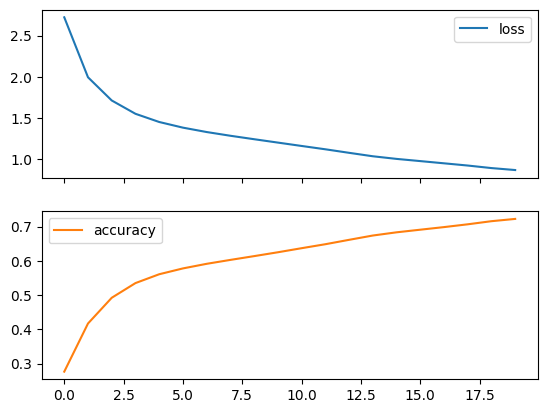

In [44]:
history_df.plot(y=['loss','accuracy'], subplots=True);

## Text Generation 🧞

In [49]:
char_to_id.get_vocabulary()[:5]

['[UNK]', ',', 'p', 'b', 'Y']

In [205]:
class TextGen(tf.keras.Model):
  def __init__(self, char_to_id, id_to_char, model, temperature=1.0):
    super().__init__(self,)
    self.char_to_id = char_to_id 
    self.id_to_char = id_to_char
    self.model = model
    self.temperature = temperature
  
   # Create a mask to prevent "[UNK]" from being generated.
    skip_ids = char_to_id(['[UNK]'])[:,None]
    mask = tf.SparseTensor(indices=skip_ids, values=[-np.inf]*len(skip_ids), dense_shape=(char_to_id.vocabulary_size(),))
    self.predicition_mask = tf.sparse.to_dense(mask)
  
  @tf.function
  def predict_next(self, inputs, state=None):
     chars = tf.strings.unicode_split(input=inputs, input_encoding='UTF-8')
     #  convert ragged tensor to tensor
     ids = self.char_to_id(chars).to_tensor()

     # [batch, seq] --> [batch, seq, vocab-size]
     predictions, rnn_state = self.model(inputs=ids, state=state, return_state=True)

     #  take the last sequence
     y_pred = predictions[:,-1,:]
     #  randomness
     y_pred = y_pred/self.temperature
     #  add the mask to remove [UNK] token 
     y_pred = y_pred + self.predicition_mask

     #  SAMPLE
     sample = tf.random.categorical(logits=y_pred, num_samples=1)
     sample = tf.squeeze(sample, axis=-1)
    #  convert from tokens to chars
     y_pred_chars = self.id_to_char(sample)
     return y_pred_chars, rnn_state


In [206]:
text_generator = TextGen(char_to_id=char_to_id, id_to_char=id_to_char, model=model, temperature=1.0)

In [207]:
# lets check this out 
next_char, rnn_state = text_generator.predict_next(inputs=tf.constant(['ROMEO:']))

### Sample Text Generation

In [221]:
next_char = tf.constant(['ROMEO:'])
results = [next_char]
state=None
for i in range(1000):
  next_char, state = text_generator.predict_next(next_char, state)
  results.append(next_char)
  

In [222]:
final_result = tf.strings.reduce_join(results, axis=0)

In [223]:
print(final_result[0].numpy().decode(encoding='UTF-8'))

ROMEO:
My grief full-satisfy!

Second Murderer:
A motter, this is most patrice, I come to Scanla'
Lorge? where ropes this bust but kneel to his injury!
It will I. Viel'd cries 'tis there puts your
bashappeated and fix'd, yea, now, by your disposition,
Your officers abdures makes
I promise and in the gods, and did thou named.

ROMEO:
I'll paint your loaghs, hillmis-worthy Burnen
Bick aufther that she must call home some golden hit;
Bage for the cerate, the world will ertar
me.

RIVENS:
She did dismal day that gives
He torture, the sauty day doth know It whose flist
well-fellow! therefore I'll father from the dog, and I'll lay enough too the woo'd as y.
Rame come, yet begun tild not out
The ordany us in Visit of a doy,
The rest will have you be these well-steal'd displeased lives.
Did merrier thing you are old enough to be most hour.

ANGELO:
What, do you make
a music knave that she must weep and all where
I have wants thy shoulder would say theretoness,
The best may be spokeness? Come, 